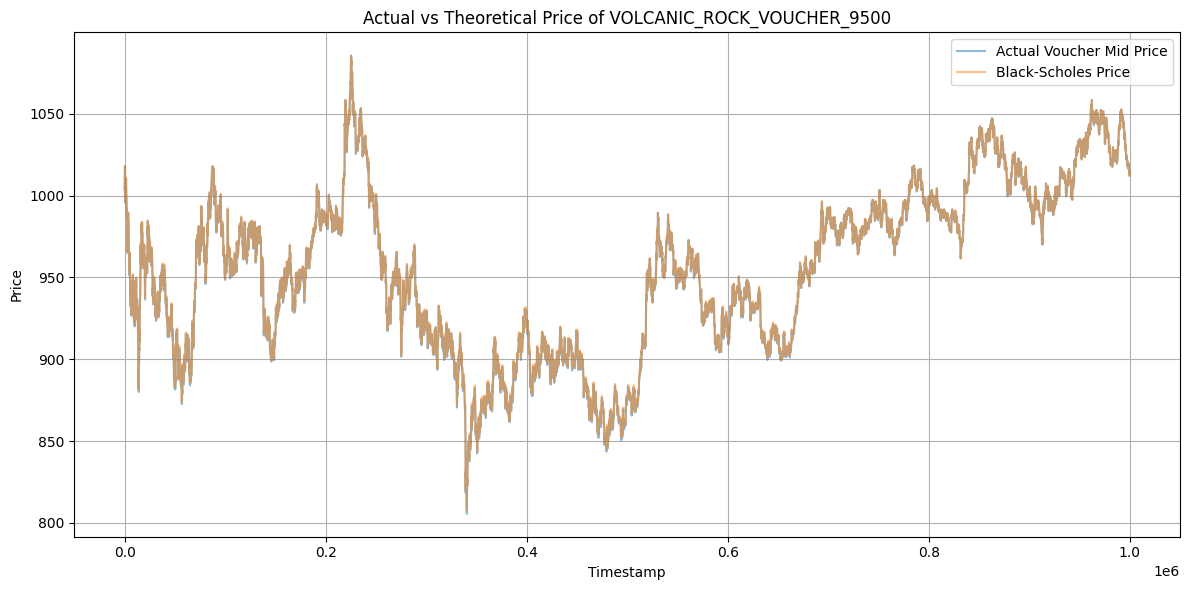

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula for a European Call Option
def black_scholes_call_price(S, K, T, r, sigma):
    if S <= 0 or sigma <= 0 or T <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Load CSV-like data
data = pd.read_csv("round-3-island-data-bottle/prices_round_3_day_0.csv", sep=';')

# Convert necessary columns to numeric
data['mid_price'] = pd.to_numeric(data['mid_price'], errors='coerce')
data['timestamp'] = pd.to_numeric(data['timestamp'], errors='coerce')

# Filter product types
rock_data = data[data['product'] == 'VOLCANIC_ROCK'].copy()
voucher_data = data[data['product'] == 'VOLCANIC_ROCK_VOUCHER_9500'].copy()

# Estimate volatility from log returns of underlying asset
rock_data = rock_data.sort_values(by='timestamp')
rock_data['log_return'] = np.log(rock_data['mid_price'] / rock_data['mid_price'].shift(1))
volatility = rock_data['log_return'].std() * np.sqrt(1_000_000)  # Annualize from per-tick std

# Constants
K = 9500
total_time = 8 / 365  # in years
r = 0

# Interpolate S (underlying price) for each voucher timestamp
interpolated_S = np.interp(voucher_data['timestamp'], rock_data['timestamp'], rock_data['mid_price'])

# Compute T per row based on how much time is left until expiration
# 1,000,000 timestamps/day × 5 days = 5,000,000 ticks total
ticks_per_day = 1_000_000
total_ticks = 8 * ticks_per_day
voucher_data = voucher_data.copy()
voucher_data['S'] = interpolated_S
voucher_data['T'] = (total_ticks - voucher_data['timestamp']) / total_ticks * total_time
voucher_data['bs_price'] = voucher_data.apply(lambda row: black_scholes_call_price(row['S'], K, row['T'], r, volatility), axis=1)

# Plot actual vs theoretical
plt.figure(figsize=(12, 6))
plt.plot(voucher_data['timestamp'], voucher_data['mid_price'], label='Actual Voucher Mid Price', alpha=0.5)
plt.plot(voucher_data['timestamp'], voucher_data['bs_price'], label='Black-Scholes Price', alpha=0.5)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Actual vs Theoretical Price of VOLCANIC_ROCK_VOUCHER_9500')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

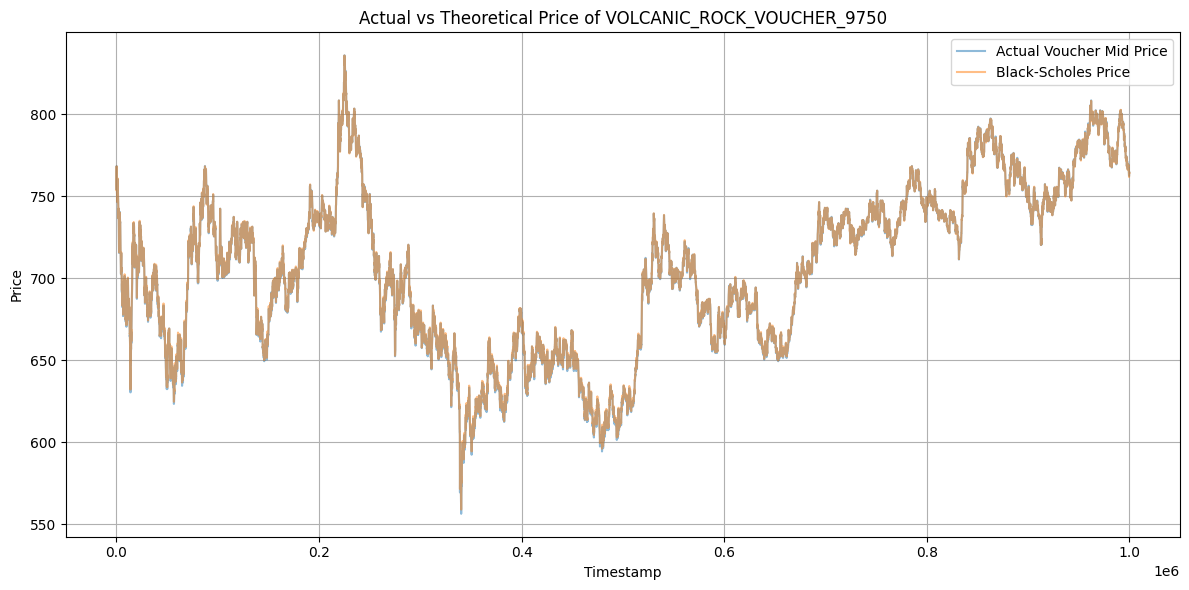

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula for a European Call Option
def black_scholes_call_price(S, K, T, r, sigma):
    if S <= 0 or sigma <= 0 or T <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Load CSV-like data
data = pd.read_csv("round-3-island-data-bottle/prices_round_3_day_0.csv", sep=';')

# Convert necessary columns to numeric
data['mid_price'] = pd.to_numeric(data['mid_price'], errors='coerce')
data['timestamp'] = pd.to_numeric(data['timestamp'], errors='coerce')

# Filter product types
rock_data = data[data['product'] == 'VOLCANIC_ROCK'].copy()
voucher_data = data[data['product'] == 'VOLCANIC_ROCK_VOUCHER_9750'].copy()

# Estimate volatility from log returns of underlying asset
rock_data = rock_data.sort_values(by='timestamp')
rock_data['log_return'] = np.log(rock_data['mid_price'] / rock_data['mid_price'].shift(1))
volatility = rock_data['log_return'].std() * np.sqrt(1_000_000)  # Annualize from per-tick std

# Constants
K = 9750
total_time = 5 / 365  # in years
r = 0

# Interpolate S (underlying price) for each voucher timestamp
interpolated_S = np.interp(voucher_data['timestamp'], rock_data['timestamp'], rock_data['mid_price'])

# Compute T per row based on how much time is left until expiration
# 1,000,000 timestamps/day × 5 days = 5,000,000 ticks total
ticks_per_day = 1_000_000
total_ticks = 5 * ticks_per_day
voucher_data = voucher_data.copy()
voucher_data['S'] = interpolated_S
voucher_data['T'] = (total_ticks - voucher_data['timestamp']) / total_ticks * total_time
voucher_data['bs_price'] = voucher_data.apply(lambda row: black_scholes_call_price(row['S'], K, row['T'], r, volatility), axis=1)

# Plot actual vs theoretical
plt.figure(figsize=(12, 6))
plt.plot(voucher_data['timestamp'], voucher_data['mid_price'], label='Actual Voucher Mid Price', alpha=0.5)
plt.plot(voucher_data['timestamp'], voucher_data['bs_price'], label='Black-Scholes Price', alpha=0.5)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Actual vs Theoretical Price of VOLCANIC_ROCK_VOUCHER_9750')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

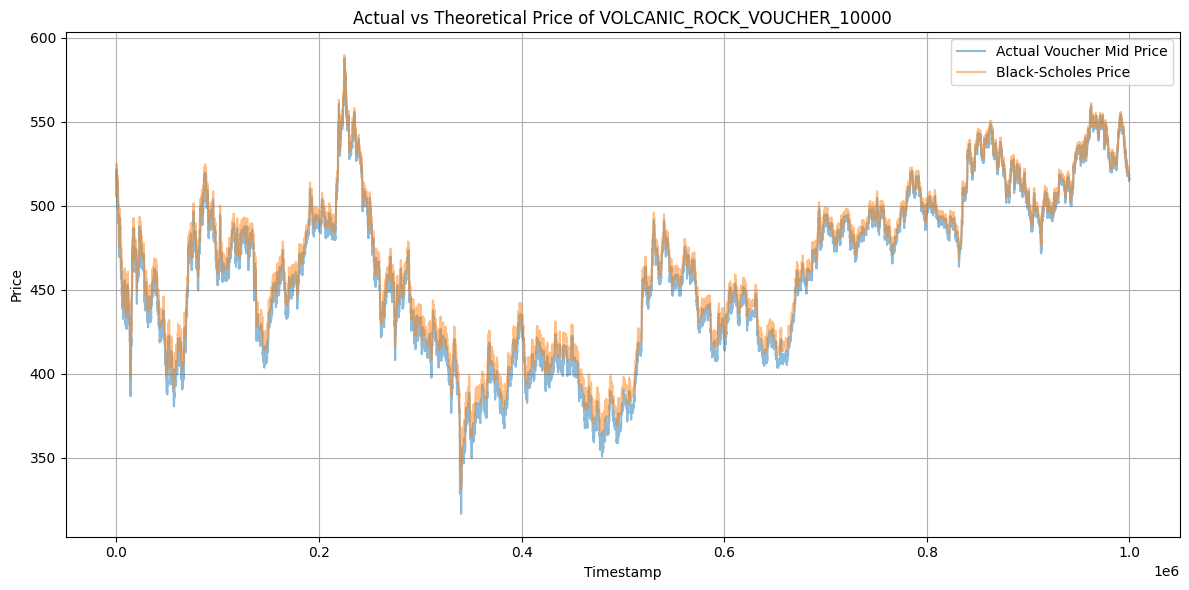

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula for a European Call Option
def black_scholes_call_price(S, K, T, r, sigma):
    if S <= 0 or sigma <= 0 or T <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Load CSV-like data
data = pd.read_csv("round-3-island-data-bottle/prices_round_3_day_0.csv", sep=';')

# Convert necessary columns to numeric
data['mid_price'] = pd.to_numeric(data['mid_price'], errors='coerce')
data['timestamp'] = pd.to_numeric(data['timestamp'], errors='coerce')

# Filter product types
rock_data = data[data['product'] == 'VOLCANIC_ROCK'].copy()
voucher_data = data[data['product'] == 'VOLCANIC_ROCK_VOUCHER_10000'].copy()

# Estimate volatility from log returns of underlying asset
rock_data = rock_data.sort_values(by='timestamp')
rock_data['log_return'] = np.log(rock_data['mid_price'] / rock_data['mid_price'].shift(1))
volatility = rock_data['log_return'].std() * np.sqrt(1_000_000)  # Annualize from per-tick std

# Constants
K = 10000
total_time = 5 / 365  # in years
r = 0

# Interpolate S (underlying price) for each voucher timestamp
interpolated_S = np.interp(voucher_data['timestamp'], rock_data['timestamp'], rock_data['mid_price'])

# Compute T per row based on how much time is left until expiration
# 1,000,000 timestamps/day × 5 days = 5,000,000 ticks total
ticks_per_day = 1_000_000
total_ticks = 5 * ticks_per_day
voucher_data = voucher_data.copy()
voucher_data['S'] = interpolated_S
voucher_data['T'] = (total_ticks - voucher_data['timestamp']) / total_ticks * total_time
voucher_data['bs_price'] = voucher_data.apply(lambda row: black_scholes_call_price(row['S'], K, row['T'], r, volatility), axis=1)

# Plot actual vs theoretical
plt.figure(figsize=(12, 6))
plt.plot(voucher_data['timestamp'], voucher_data['mid_price'], label='Actual Voucher Mid Price', alpha=0.5)
plt.plot(voucher_data['timestamp'], voucher_data['bs_price'], label='Black-Scholes Price', alpha=0.5)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Actual vs Theoretical Price of VOLCANIC_ROCK_VOUCHER_10000')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

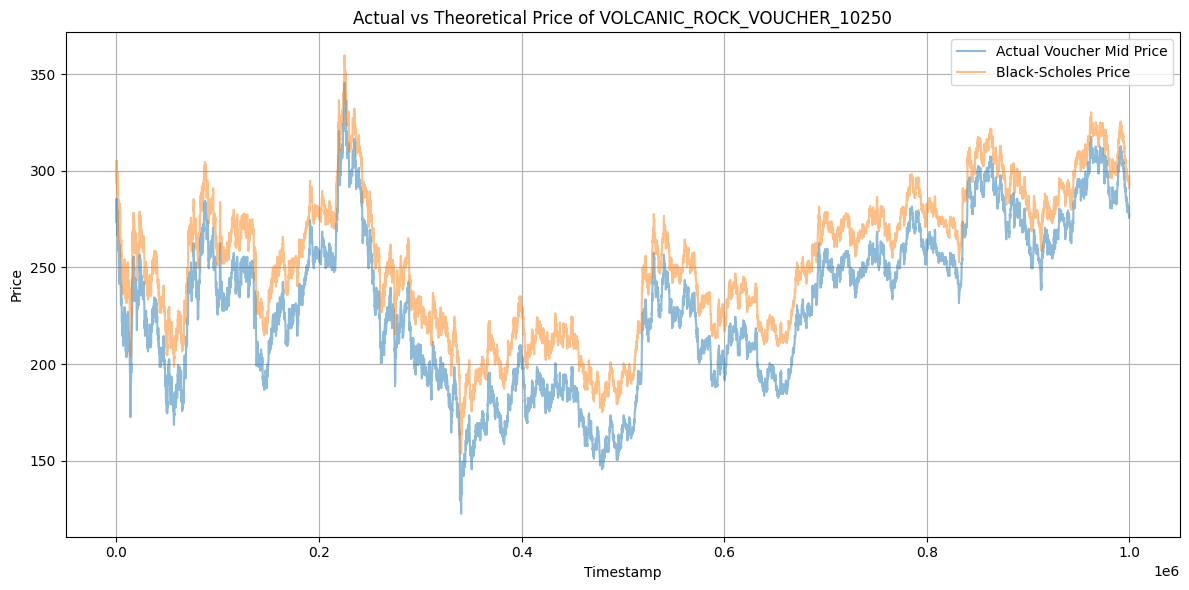

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula for a European Call Option
def black_scholes_call_price(S, K, T, r, sigma):
    if S <= 0 or sigma <= 0 or T <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Load CSV-like data
data = pd.read_csv("round-3-island-data-bottle/prices_round_3_day_0.csv", sep=';')

# Convert necessary columns to numeric
data['mid_price'] = pd.to_numeric(data['mid_price'], errors='coerce')
data['timestamp'] = pd.to_numeric(data['timestamp'], errors='coerce')

# Filter product types
rock_data = data[data['product'] == 'VOLCANIC_ROCK'].copy()
voucher_data = data[data['product'] == 'VOLCANIC_ROCK_VOUCHER_10250'].copy()

# Estimate volatility from log returns of underlying asset
rock_data = rock_data.sort_values(by='timestamp')
rock_data['log_return'] = np.log(rock_data['mid_price'] / rock_data['mid_price'].shift(1))
volatility = rock_data['log_return'].std() * np.sqrt(1_000_000)  # Annualize from per-tick std

# Constants
K = 10250
total_time = 5 / 365  # in years
r = 0

# Interpolate S (underlying price) for each voucher timestamp
interpolated_S = np.interp(voucher_data['timestamp'], rock_data['timestamp'], rock_data['mid_price'])

# Compute T per row based on how much time is left until expiration
# 1,000,000 timestamps/day × 5 days = 5,000,000 ticks total
ticks_per_day = 1_000_000
total_ticks = 5 * ticks_per_day
voucher_data = voucher_data.copy()
voucher_data['S'] = interpolated_S
voucher_data['T'] = (total_ticks - voucher_data['timestamp']) / total_ticks * total_time
voucher_data['bs_price'] = voucher_data.apply(lambda row: black_scholes_call_price(row['S'], K, row['T'], r, volatility), axis=1)

# Plot actual vs theoretical
plt.figure(figsize=(12, 6))
plt.plot(voucher_data['timestamp'], voucher_data['mid_price'], label='Actual Voucher Mid Price', alpha=0.5)
plt.plot(voucher_data['timestamp'], voucher_data['bs_price'], label='Black-Scholes Price', alpha=0.5)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Actual vs Theoretical Price of VOLCANIC_ROCK_VOUCHER_10250')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

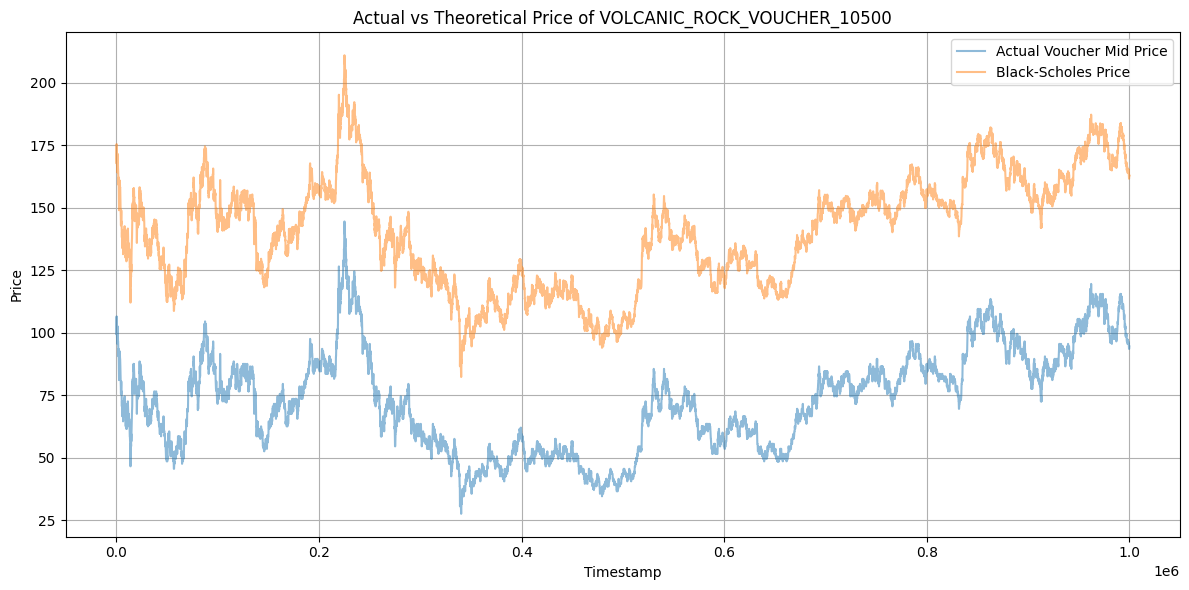

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Black-Scholes formula for a European Call Option
def black_scholes_call_price(S, K, T, r, sigma):
    if S <= 0 or sigma <= 0 or T <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Load CSV-like data
data = pd.read_csv("round-3-island-data-bottle/prices_round_3_day_0.csv", sep=';')

# Convert necessary columns to numeric
data['mid_price'] = pd.to_numeric(data['mid_price'], errors='coerce')
data['timestamp'] = pd.to_numeric(data['timestamp'], errors='coerce')

# Filter product types
rock_data = data[data['product'] == 'VOLCANIC_ROCK'].copy()
voucher_data = data[data['product'] == 'VOLCANIC_ROCK_VOUCHER_10500'].copy()

# Estimate volatility from log returns of underlying asset
rock_data = rock_data.sort_values(by='timestamp')
rock_data['log_return'] = np.log(rock_data['mid_price'] / rock_data['mid_price'].shift(1))
volatility = rock_data['log_return'].std() * np.sqrt(1_000_000)  # Annualize from per-tick std

# Constants
K = 10500
total_time = 5 / 365  # in years
r = 0

# Interpolate S (underlying price) for each voucher timestamp
interpolated_S = np.interp(voucher_data['timestamp'], rock_data['timestamp'], rock_data['mid_price'])

# Compute T per row based on how much time is left until expiration
# 1,000,000 timestamps/day × 5 days = 5,000,000 ticks total
ticks_per_day = 1_000_000
total_ticks = 5 * ticks_per_day
voucher_data = voucher_data.copy()
voucher_data['S'] = interpolated_S
voucher_data['T'] = (total_ticks - voucher_data['timestamp']) / total_ticks * total_time
voucher_data['bs_price'] = voucher_data.apply(lambda row: black_scholes_call_price(row['S'], K, row['T'], r, volatility), axis=1)

# Plot actual vs theoretical
plt.figure(figsize=(12, 6))
plt.plot(voucher_data['timestamp'], voucher_data['mid_price'], label='Actual Voucher Mid Price', alpha=0.5)
plt.plot(voucher_data['timestamp'], voucher_data['bs_price'], label='Black-Scholes Price', alpha=0.5)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Actual vs Theoretical Price of VOLCANIC_ROCK_VOUCHER_10500')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()